In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sp
import time
from sklearn.cross_decomposition import PLSRegression

Here, we create a $n\times m$ matrix $X$ and a $n\times p$ matrix $Y$, where
* $n$ is the number of samples;
* $m$ is the number of human genetic variants;
* $p$ is the number of pathogen genetic variants.

In [84]:
S = (v.X).T @ v.Y
n = S.T @ S
eigenvalues, eigenvectors = np.linalg.eig(n)

In [88]:
S.size

50

In [56]:
n @ q

array([ 55.68946576, 186.73702662,  83.76003807,  36.47353508,
        36.47353508])

In [176]:
def transfer(mat, model = 'additive'):
    if model == 'additive':
        return mat/2
    elif model == 'force':
        tmp = np.where(mat >= 0.5, 1, mat)
        return np.where(tmp < 0.5, 0, tmp)
    elif model == 'dominant':
        return np.where(mat == 2, 1, mat)
    else:
        tmp = np.where(mat == 2, 1, mat)
        return np.where(tmp == 1, 0, tmp)
    
def affect(mat, weight = np.array([1]), model = 'additive', encode = True):
    mat = transfer(mat, model)
    dosage = mat*weight
    if len(weight) != 1:
        dosage = np.sum(dosage, axis = 1)
    return transfer(dosage, model = 'force')
class Human:
    def __init__(self, n_pop, n_var, ploidy = 2):
        self.n_pop = n_pop
        self.n_var = n_var
        self.ploidy = ploidy
        self.X = np.random.randint(low = 0, high = ploidy + 1, size =(n_pop, n_var)) # nxm matrix X

class Virus:
    def __init__(self, human, n_var, ploidy = 1):
        self.X = human.X
        self.n_pop = self.X.shape[0]
        self.n_var = n_var
        self.ploidy = ploidy
        self.Y = np.random.randint(low = 0, high = ploidy + 1, size =(self.n_pop, self.n_var)) # nxp matrix Y
# Returns the means of the matrix for centralization
def getMean(mat):
    return np.tile(np.mean(mat, axis = 0),(mat.shape[0],1))

# This function calculates the variance in the original matrix
def getVariance(mat):
    totalVar = 0
    for i in range(mat.shape[1]):
        totalVar += np.var(mat[:,i])
    return totalVar*(mat.shape[0])/(mat.shape[0] - 1)

# Plot variance graph 
def plotVar(varXAry, varYAry, varXTotal, varYTotal):
    numFactor = len(varXAry)
    numFactorAry = np.arange(1, numFactor + 1)
    plt.plot(numFactorAry, np.cumsum(varXAry/varXTotal), color = 'c', label = 'varX')
    plt.plot(numFactorAry, np.cumsum(varYAry)/varYTotal, color = 'm', label = 'varY')
    plt.axhline(y = 1, color = 'g', linestyle = '--')
    plt.xlabel('number of factors')
    plt.ylabel('percent variance explained')
    plt.legend()
    plt.title('variance explained in $X$ and $Y$')
    plt.show()
    
# The SIMPLS algorithm
def SIMPLS(X, Y, numFactor):
    X = np.matrix(X)
    Y = np.matrix(Y)
    
    varXAry = []
    varYAry = []
    varSAry = []
    
    numSample = X.shape[0]
    numHuman = X.shape[1]
    numPathogen = Y.shape[1]
    
    Y0 = Y - getMean(Y) # Centralize Y
    S = (X.T @ Y0) # Calculate S
    for a in range(1, numFactor+1):
        eigenvalues, eigenvectors = np.linalg.eig(S.T @ S)
        dominant_index = np.argmax(np.abs(eigenvalues))
        q = np.matrix(eigenvectors[:, dominant_index])
        r = S @ q
        t = X @ r
        t = t - np.mean(t)
        normt = np.sqrt(t.T @ t)
        t = t/normt
        r = r/np.sqrt(r.T @ r)
        p = X.T @ t
        q = Y0.T @ t
        u = Y0 @ q
        v = p
        if a > 1:
            v = v - V @ (V.T @ p)
            u = u - T @ (T.T @ u)
        v = v/np.sqrt(v.T @ v)
        S = S - v @ (v.T @ S)
        R, T, P, Q, U, V = r, t, p, q, u, v
        if a == 1:
            T_mat = T
            R_mat = R
        else:
            T_mat = np.hstack([T_mat, T])
            R_mat = np.hstack([R_mat, R])
        varXAry.append(np.diag((P.T @ P)/(numSample - 1))[0])
        varYAry.append(np.diag((Q.T @ Q)/(numSample - 1))[0])
        # If the information is already extracted, stop the algorithm immediately
#         if abs(np.sum(varYAry) - getVariance(Y)) < 1e-10:
#             B = R @ Q.T
#             h = np.diag(T @ T.T) + 1/numSample
#             return B, tAry, varXAry, varYAry, varSAry
    B = R_mat @ Q.T
    h = np.diag(T_mat @ T_mat.T) + 1/numSample
    return B, tAry, varXAry, varYAry, varSAry, rAry

In [313]:
h = Human(20, 100)
v = Virus(h, 10)
# v.Y[:,2] = v.X[:, 5]

In [314]:
v.X

array([[1, 0, 1, ..., 1, 0, 2],
       [0, 2, 2, ..., 1, 2, 2],
       [1, 2, 0, ..., 0, 0, 1],
       ...,
       [2, 1, 0, ..., 0, 1, 0],
       [2, 2, 1, ..., 2, 2, 1],
       [2, 1, 1, ..., 1, 0, 1]])

In [315]:
v.Y

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
       [0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]])

In [158]:
varX1Total = getVariance(v.X)
varY1Total = getVariance(v.Y)

In [159]:
(v.X - getMean(v.X)) @ B + getMean(v.Y)

matrix([[0.5       +0.j, 0.4794412 +0.j, 0.50509717+0.j, 0.24950829+0.j,
         0.49950829+0.j],
        [0.5       +0.j, 0.56330078+0.j, 0.48430577+0.j, 0.25151397+0.j,
         0.50151397+0.j],
        [0.5       +0.j, 0.54724313+0.j, 0.48828696+0.j, 0.25112992+0.j,
         0.50112992+0.j],
        [0.5       +0.j, 0.41001489+0.j, 0.52231011+0.j, 0.24784782+0.j,
         0.49784782+0.j]])

In [160]:
varS1Ary

[]

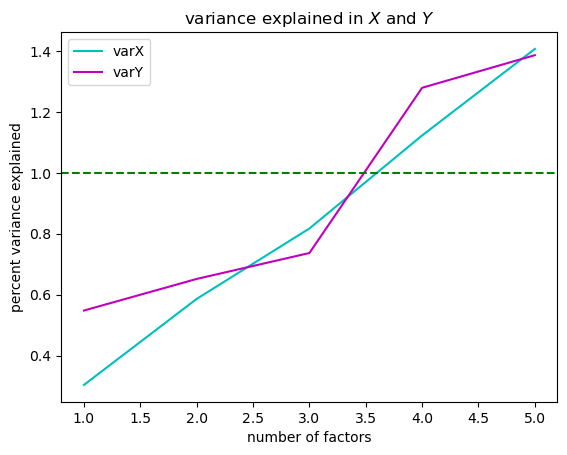

In [161]:
plotVar(varX1Ary, varY1Ary, varX1Total, varY1Total)

In [321]:
def SIMPLS(X, Y, numFactor, tolerance = 1e-6):
    X = np.matrix(X)
    Y = np.matrix(Y)
    
    varXAry = []
    varYAry = []
    varSAry = []
    
    numSample = X.shape[0]
    numHuman = X.shape[1]
    numPathogen = Y.shape[1]
    eig_ary = []
    
    Y0 = Y - getMean(Y) # Centralize Y
    S = (X.T @ Y0) # Calculate S
    for a in range(1, numFactor+1):
#         eigenvalues, eigenvectors = np.linalg.eig(S.T @ S)
#         dominant_index = np.argmax(np.abs(eigenvalues))
#         q = np.matrix(eigenvectors[:, dominant_index])

        eigenvalues, eigenvectors = sp.eigh(S.T @ S)
#         dominant_eigenvalue = eigenvalues[-1]
        q = np.matrix(eigenvectors[:, -1]).T
        r = S @ q
        t = X @ r
        t = t - np.mean(t)
        normt = np.sqrt(t.T @ t)
        t = t/normt
        r = r/np.sqrt(r.T @ r)
        p = X.T @ t
        q = Y0.T @ t
        u = Y0 @ q
        v = p
        if a > 1:
            v = v - V @ (V.T @ p)
            u = u - T @ (T.T @ u)
        v = v/np.sqrt(v.T @ v)
        S = S - v @ (v.T @ S)
        if a == 1:
            R, T, P, Q, U, V = r, t, p, q, u, v
        else:
            R = np.hstack([R, r])
            T = np.hstack([T, t])
            P = np.hstack([P, p])
            Q = np.hstack([Q, q])
            U = np.hstack([U, u])
            V = np.hstack([V, v])
        varXAry.append(np.diag((P.T @ P)/(numSample - 1))[0])
        varYAry.append(np.diag((Q.T @ Q)/(numSample - 1))[0])
        # tolerance
        if abs(np.sum(varYAry) - getVariance(Y)) < tolerance:
            B = R @ Q.T
            h = np.diag(T @ T.T) + 1/numSample
            return B, T, R
    B = R @ Q.T
    h = np.diag(T @ T.T) + 1/numSample
    return B, T, R

In [322]:
test3X = np.array([[-4,2,1], [-4,-2,-1],[4,2,-1],[4,-2,1]])
test3Y = np.array([[430, -94], [-436, 12], [-361, -22], [367, 104]])
B3, T3, R3 = SIMPLS(test3X, test3Y, 3)

In [323]:
def bootstrap_pls(X, Y, n_components=3, n_bootstraps=1000):
    B,T,R = SIMPLS(X, Y, numFactor = n_components)
    original_coefs = B
    
    bootstrap_coefs = np.zeros((n_bootstraps, X.shape[1], Y.shape[1]))
    
    for i in range(n_bootstraps):
        indices = np.random.choice(np.arange(X.shape[0]), size=X.shape[0], replace=True)
        X_boot = X[indices]
        Y_boot = Y[indices]
        B,T,R = SIMPLS(X_boot, Y_boot, numFactor = n_components)
        bootstrap_coefs[i] = B

    # Calculate means and standard errors
    coef_means = np.mean(bootstrap_coefs, axis=0)
    coef_stds = np.std(bootstrap_coefs, axis=0)
    
    return original_coefs, coef_means, coef_stds

In [324]:
v.X

array([[1, 0, 1, ..., 1, 0, 2],
       [0, 2, 2, ..., 1, 2, 2],
       [1, 2, 0, ..., 0, 0, 1],
       ...,
       [2, 1, 0, ..., 0, 1, 0],
       [2, 2, 1, ..., 2, 2, 1],
       [2, 1, 1, ..., 1, 0, 1]])

In [325]:
v.Y

array([[0, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 1, 1, 1, 1, 0, 1],
       [0, 1, 1, 1, 1, 0, 0, 1, 0, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 1, 1, 0, 0, 0],
       [1, 0, 1, 1, 1, 1, 0, 1, 1, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 0, 1, 1, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
       [1, 1, 1, 1, 0, 1, 0, 1, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 1, 0]])

In [326]:
def jackknife_pls(X, Y, n_components=3):
    n_samples = X.shape[0]
    B,T,R = SIMPLS(X, Y, numFactor = n_components)
    B_original = B
    
    jackknife_coefs = np.zeros((n_samples, X.shape[1], Y.shape[1]))
    
    for i in range(n_samples):
        X_jack = np.delete(X, i, axis=0)
        Y_jack = np.delete(Y, i, axis=0)
        B,T,R = SIMPLS(X_jack, Y_jack, numFactor = n_components)
        jackknife_coefs[i] = B
    
    coef_mean = np.mean(jackknife_coefs, axis=0)
    coef_std = np.std(jackknife_coefs, axis=0, ddof=1)
    
    t_stats = B_original / coef_std
    
    return t_stats

In [327]:
t_stats = jackknife_pls(v.X, v.Y)

In [328]:
t_stats

matrix([[-2.30355099,  2.05127306,  0.69339066,  1.17657988,  1.19614326,
         -1.77463335, -3.04351424, -0.10921281, -1.98523198,  2.68590327],
        [ 0.78373183,  1.36586603, -2.91896636,  5.92020353,  5.65441327,
          6.76136268,  1.60977375,  1.65317449, -6.33042535,  1.93720216],
        [ 2.62458589, -3.36155281, -1.59883729, -5.15850889, -6.23584339,
         -0.38143488,  5.61498215, -2.21145683,  6.57769161, -3.41070092],
        [-0.52106451,  1.10123301,  0.73246698,  0.75285639,  0.84832412,
          0.25579731, -0.22809666,  0.68134385, -0.19663109, -0.58696256],
        [ 2.37166083, -2.31751364, -4.36879665, -2.65551163, -2.9714653 ,
          1.17325067,  3.8600053 , -2.52577962,  1.10542453,  1.02105561],
        [-1.21818416, -0.21375393,  0.25824819, -2.17343351, -1.67654569,
         -3.42801373, -2.16972158, -1.28048766,  0.43481026,  1.6370281 ],
        [-1.86584194,  1.9294331 ,  2.80790382,  1.00500425,  1.11432996,
         -0.91765453, -1.6884050